### b) Import data

In [ ]:
import pandas as pd

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [ ]:
import pandas as pd
import glob
from scipy.stats import bootstrap
import numpy as np
import csv
import seaborn as seaborn
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import statsmodels.api as sm
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import (confusion_matrix,
                           accuracy_score)
from sklearn import metrics
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB

In [432]:
files = glob.glob('../AreM/**/*.csv', 
                   recursive = True)
test = ["bending1/dataset1.csv","bending1/dataset2.csv","bending2/dataset1.csv","bending2/dataset2.csv", "cycling/dataset1.csv", "cycling/dataset2.csv",
       "cycling/dataset3.csv", "lying/dataset1.csv", "lying/dataset2.csv", "lying/dataset3.csv", "sitting/dataset1.csv", "sitting/dataset2.csv", "sitting/dataset3.csv",
       "standing/dataset1.csv", "standing/dataset2.csv", "standing/dataset3.csv", "walking/dataset1.csv", "walking/dataset2.csv", "walking/dataset3.csv"]
test_name = []
train_name = []
for file in files:
    new_file = file.split('/')[-2:]
    new_name = '/'.join(name for name in new_file)
    if new_name in test:
        test_name.append(file)
    else:
        train_name.append(file)


In [126]:
appended_data_train = []
appended_data_test = []
for file in train_name:
    ActuralFile_train = pd.read_csv(file, skiprows = 4, error_bad_lines = False, warn_bad_lines = False)
    if 'bending' in file:
        ActuralFile_train['filename'] = 'bending'
    else:
        ActuralFile_train['filename'] = 'Notbending'
    appended_data_train.append(ActuralFile_train)
for file in test_name:
    ActuralFile_test = pd.read_csv(file, skiprows = 4, error_bad_lines = False, warn_bad_lines = False)
    if 'bending' in file:
        ActuralFile_test['filename'] = 'bending'
    else:
        ActuralFile_test['filename'] = 'Notbending'
    appended_data_test.append(ActuralFile_test)
trainData = pd.concat(appended_data_train, axis = 0, ignore_index = True)
testData = pd.concat(appended_data_test, axis = 0, ignore_index = True)
trainData

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23,filename
0,0,42.00,0.00,18.50,0.50,12.00,0.00,bending
1,250,42.00,0.00,18.00,0.00,11.33,0.94,bending
2,500,42.75,0.43,16.75,1.79,18.25,0.43,bending
3,750,42.50,0.50,16.75,0.83,19.00,1.22,bending
4,1000,43.00,0.82,16.25,0.83,18.00,0.00,bending
...,...,...,...,...,...,...,...,...
33114,118750,41.75,1.79,11.00,6.00,16.67,2.49,Notbending
33115,119000,36.33,0.47,16.00,3.16,20.33,1.70,Notbending
33116,119250,31.50,1.50,21.00,0.00,12.25,7.12,Notbending
33117,119500,34.25,6.38,12.67,2.49,15.25,4.21,Notbending


In [47]:
# Determine which file has the syntex error
for file in train_name:
    try:
        pd.read_csv(file, skiprows = 4, error_bad_lines = False, warn_bad_lines = False)
    except:
        print("The file " + file + " is bad")

### c) Feature Extraction

**i) Research what types of time-domain features are usually used in time series
classification and list them (examples are minimum, maximum, mean, etc).**

* Mean
* Standard Deviation
* Skeweness
* Maximum and Minimum
* first quartile, second quartile, third quartile

**ii) Extract the time-domain features minimum, maximum, mean, median, standard
deviation, first quartile, and third quartile for all of the 6 time series
in each instance. You are free to normalize/standardize features or use them
directly.**

In [127]:
variable_names = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
column_names = []
for name in variable_names:
    column_names.append(name + 'Min')
    column_names.append(name + 'Max')
    column_names.append(name + 'Mean')
    column_names.append(name + 'Median')
    column_names.append(name + 'Sd')
    column_names.append(name + 'FirstQuart')
    column_names.append(name + 'ThirdQuart')
df = pd.DataFrame(columns = column_names)
for file in files:
    newline = []
    new_file = file.split('/')[-2:]
    new_name = '/'.join(name for name in new_file)
    if new_name != 'bending2/dataset4.csv':
        newfile = pd.read_csv(file, skiprows = 4, error_bad_lines = False, warn_bad_lines = False)
    else:
        headers = ['columns', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
        newfile = pd.read_csv('../AreM/bending2/dataset4.csv', skiprows = 5, error_bad_lines = False, warn_bad_lines = False, sep = '\s+', names = headers)
    for columnName in variable_names:
        newline.append(newfile[columnName].min())
        newline.append(newfile[columnName].max())
        newline.append(newfile[columnName].mean())
        newline.append(newfile[columnName].median())
        newline.append(newfile[columnName].std())
        newline.append(newfile[columnName].quantile(0.25))
        newline.append(newfile[columnName].quantile(0.75))
    df.loc[len(df.index)] = newline
df

,avg_rss12Min,avg_rss12Max,avg_rss12Mean,avg_rss12Median,avg_rss12Sd,avg_rss12FirstQuart,avg_rss12ThirdQuart,var_rss12Min,var_rss12Max,var_rss12Mean,...,avg_rss23Sd,avg_rss23FirstQuart,avg_rss23ThirdQuart,var_rss23Min,var_rss23Max,var_rss23Mean,var_rss23Median,var_rss23Sd,var_rss23FirstQuart,var_rss23ThirdQuart
0,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.67,0.0,1.50,0.413125,...,3.318301,20.5000,23.7500,0.0,2.96,0.555313,0.490,0.487826,0.0000,0.8300
1,37.00,48.00,43.454958,43.25,1.386098,42.5000,45.00,0.0,1.58,0.378083,...,2.488862,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.8700
2,33.00,47.75,42.179813,43.50,3.670666,39.1500,45.00,0.0,3.00,0.696042,...,3.849448,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000
3,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,0.0,2.83,0.535979,...,2.411026,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000
4,37.25,45.00,40.624792,40.50,1.476967,39.2500,42.00,0.0,1.30,0.358604,...,2.188449,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,18.50,44.25,35.752354,36.00,4.614802,33.0000,39.33,0.0,12.60,3.328104,...,3.120057,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.0600
84,24.25,45.00,37.177042,36.25,3.581301,34.5000,40.25,0.0,8.58,2.374208,...,2.890347,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.9000
85,23.33,43.50,36.244083,36.75,3.822016,33.4575,39.25,0.0,9.71,2.736021,...,3.617702,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.963685,2.1700,4.6175
86,26.25,44.25,36.957458,36.29,3.434863,34.5000,40.25,0.0,8.64,2.420083,...,2.851673,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.0300


In [52]:
# testing data
i = 0
#for file in files:
#    print(i, file)
#    i += 1
headers = ['columns', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
bending2 = pd.read_csv('../AreM/bending2/dataset4.csv', skiprows = 5, error_bad_lines = False, sep = '\s+', names = headers)
#bending2
#csv.Sniffer()
df.isnull().sum().sum()

0

#### iii) Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python's bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [51]:
# print out the standard deviation for each feature
df.std()

avg_rss12Min           9.569975
avg_rss12Max           4.394362
avg_rss12Mean          5.335700
avg_rss12Median        5.440054
avg_rss12Sd            1.772185
avg_rss12FirstQuart    6.153874
avg_rss12ThirdQuart    5.138925
var_rss12Min           0.000000
var_rss12Max           5.062729
var_rss12Mean          1.574198
var_rss12Median        1.412293
var_rss12Sd            0.884137
var_rss12FirstQuart    0.946386
var_rss12ThirdQuart    2.125399
avg_rss13Min           2.956462
avg_rss13Max           4.875137
avg_rss13Mean          4.008228
avg_rss13Median        4.036396
avg_rss13Sd            0.946670
avg_rss13FirstQuart    4.220658
avg_rss13ThirdQuart    4.171628
var_rss13Min           0.000000
var_rss13Max           2.183625
var_rss13Mean          1.166178
var_rss13Median        1.145985
var_rss13Sd            0.458283
var_rss13FirstQuart    0.843405
var_rss13ThirdQuart    1.552504
avg_rss23Min           6.124001
avg_rss23Max           5.741238
avg_rss23Mean          5.675543
avg_rss2

In [80]:
rng = np.random.default_rng()
for name in df.columns:
    originalData = df[name]
    array = np.array(originalData)
    is_all_zero = np.all((array == 0))
    if is_all_zero:
        print(name + ' ConfidenceInterval(low=0, high=0)')
    else:
        data = (list(originalData),)
        res = bootstrap(data, np.std, confidence_level = 0.9, random_state = rng)
        print(name, res.confidence_interval)

avg_rss12Min ConfidenceInterval(low=8.48737623129096, high=11.116982074572613)
avg_rss12Max ConfidenceInterval(low=3.522066739880346, high=5.528504932774657)
avg_rss12Mean ConfidenceInterval(low=4.807093583883827, high=5.985141639123407)
avg_rss12Median ConfidenceInterval(low=4.895346860547032, high=6.109762795744627)
avg_rss12Sd ConfidenceInterval(low=1.596648787485096, high=1.985628264039308)
avg_rss12FirstQuart ConfidenceInterval(low=5.650486565075227, high=6.729604098126606)
avg_rss12ThirdQuart ConfidenceInterval(low=4.435714547846143, high=5.9805568948400465)
var_rss12Min ConfidenceInterval(low=0, high=0)
var_rss12Max ConfidenceInterval(low=4.671839332195229, high=5.429436830089752)
var_rss12Mean ConfidenceInterval(low=1.4062601515981832, high=1.7111560664805006)
var_rss12Median ConfidenceInterval(low=1.2515396662278053, high=1.5526658805613964)
var_rss12Sd ConfidenceInterval(low=0.808707974989723, high=0.9435307310560523)
var_rss12FirstQuart ConfidenceInterval(low=0.8408213365292

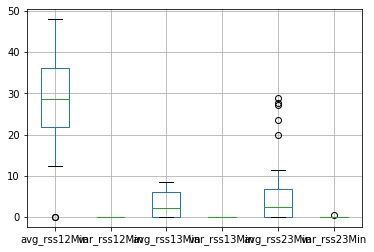

In [116]:
boxplot = df.boxplot(column = ['avg_rss12Min', 'var_rss12Min', 'avg_rss13Min', 'var_rss13Min', 'avg_rss23Min', 'var_rss23Min'])


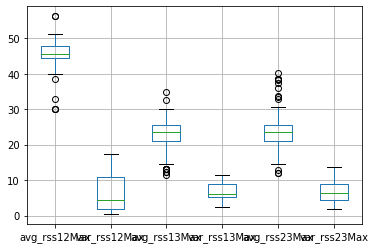

In [117]:
boxplot = df.boxplot(column = ['avg_rss12Max', 'var_rss12Max', 'avg_rss13Max', 'var_rss13Max', 'avg_rss23Max', 'var_rss23Max'])


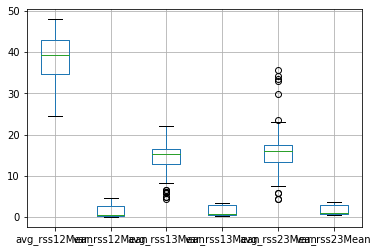

In [118]:
boxplot = df.boxplot(column = ['avg_rss12Mean', 'var_rss12Mean', 'avg_rss13Mean', 'var_rss13Mean', 'avg_rss23Mean', 'var_rss23Mean'])


I think the most three important features are Mean, Max, and Min becasue they vary a lot between each other.

### 3.4.7

### I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regressionmodel to the data, as well as a separate cubic regression, i.e. Y = β0 + β1X + β2X2 + β3X3 + ϵ

a) I think we need more information on trianing data to make the decision. But based on the question that the true relationship is close to simple linear regression, using a cubic model to fit it may cause overfitting. Thus, the RSS of the cubic model for the training data would be less.

b) If we put the situation to the test data, we also need more information to justify the answer. However, I can estimate that the linear regression would probably has less test RSS, becasue the ture relationship is simple linear regression. If we using the cubic model, we would overfitting the data and get more wrong data.

c) As it is non-linear, traing RSS of cubic regression would be less than the traing RSS of simple linear regression. Becasue in this case, a more flexible model would result in a decresing error in traing dataset.

d) As the problem has mentioned, we don't know how far the true relationship is from linear, we can't be certain about which model would has a small test RSS. If the relationship was closed to the linear than cubic, the simple linear regression would has a smaller test RSS and vice versa.

### Homework 4

### (a) Binary Classsification Using Logistic Regression

#### Assume that you want to use the training set to classify bending from other activities, i.e. you have a binary classi cation problem. Depict scatter plots of the features you speci ed in 1(c)iv extracted from time series 1, 2, and 6 of each instance, and use color to distinguish bending vs. other activities. (See p. 129 of the textbook).

In [132]:
variable_names = ['avg_rss12', 'var_rss12', 'var_rss23']
column_names = []
for name in variable_names:
    column_names.append(name + 'Min')
    column_names.append(name + 'Max')
    column_names.append(name + 'Mean')
column_names.append('filename')
df_4a = pd.DataFrame(columns = column_names)
for file in train_name:
    newline = []
    new_file = file.split('/')[-2:]
    new_name = '/'.join(name for name in new_file)
    if new_name != 'bending2/dataset4.csv':
        newfile = pd.read_csv(file, skiprows = 4, error_bad_lines = False, warn_bad_lines = False)
    else:
        headers = ['columns', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
        newfile = pd.read_csv('../AreM/bending2/dataset4.csv', skiprows = 5, error_bad_lines = False, warn_bad_lines = False, sep = '\s+', names = headers)
    for columnName in variable_names:
        newline.append(newfile[columnName].min())
        newline.append(newfile[columnName].max())
        newline.append(newfile[columnName].mean())
    if 'bending' in file:
        newline.append('bending')
    else:
        newline.append('Notbending')
    df_4a.loc[len(df_4a.index)] = newline
df_4a

,avg_rss12Min,avg_rss12Max,avg_rss12Mean,var_rss12Min,var_rss12Max,var_rss12Mean,var_rss23Min,var_rss23Max,var_rss23Mean,filename
0,36.25,48.00,43.969125,0.0,1.50,0.413125,0.0,2.96,0.555313,bending
1,37.00,48.00,43.454958,0.0,1.58,0.378083,0.0,5.26,0.679646,bending
2,33.00,47.75,42.179813,0.0,3.00,0.696042,0.0,2.18,0.613521,bending
3,33.00,45.75,41.678063,0.0,2.83,0.535979,0.0,1.79,0.383292,bending
4,35.00,47.40,43.954500,0.0,1.70,0.426250,0.0,1.79,0.493292,bending
...,...,...,...,...,...,...,...,...,...,...
64,18.50,44.25,35.752354,0.0,12.60,3.328104,0.0,9.39,3.069667,Notbending
65,24.25,45.00,37.177042,0.0,8.58,2.374208,0.0,9.34,2.921729,Notbending
66,23.33,43.50,36.244083,0.0,9.71,2.736021,0.0,11.15,3.530500,Notbending
67,26.25,44.25,36.957458,0.0,8.64,2.420083,0.0,8.34,2.934625,Notbending


/Users/mac/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/mac/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


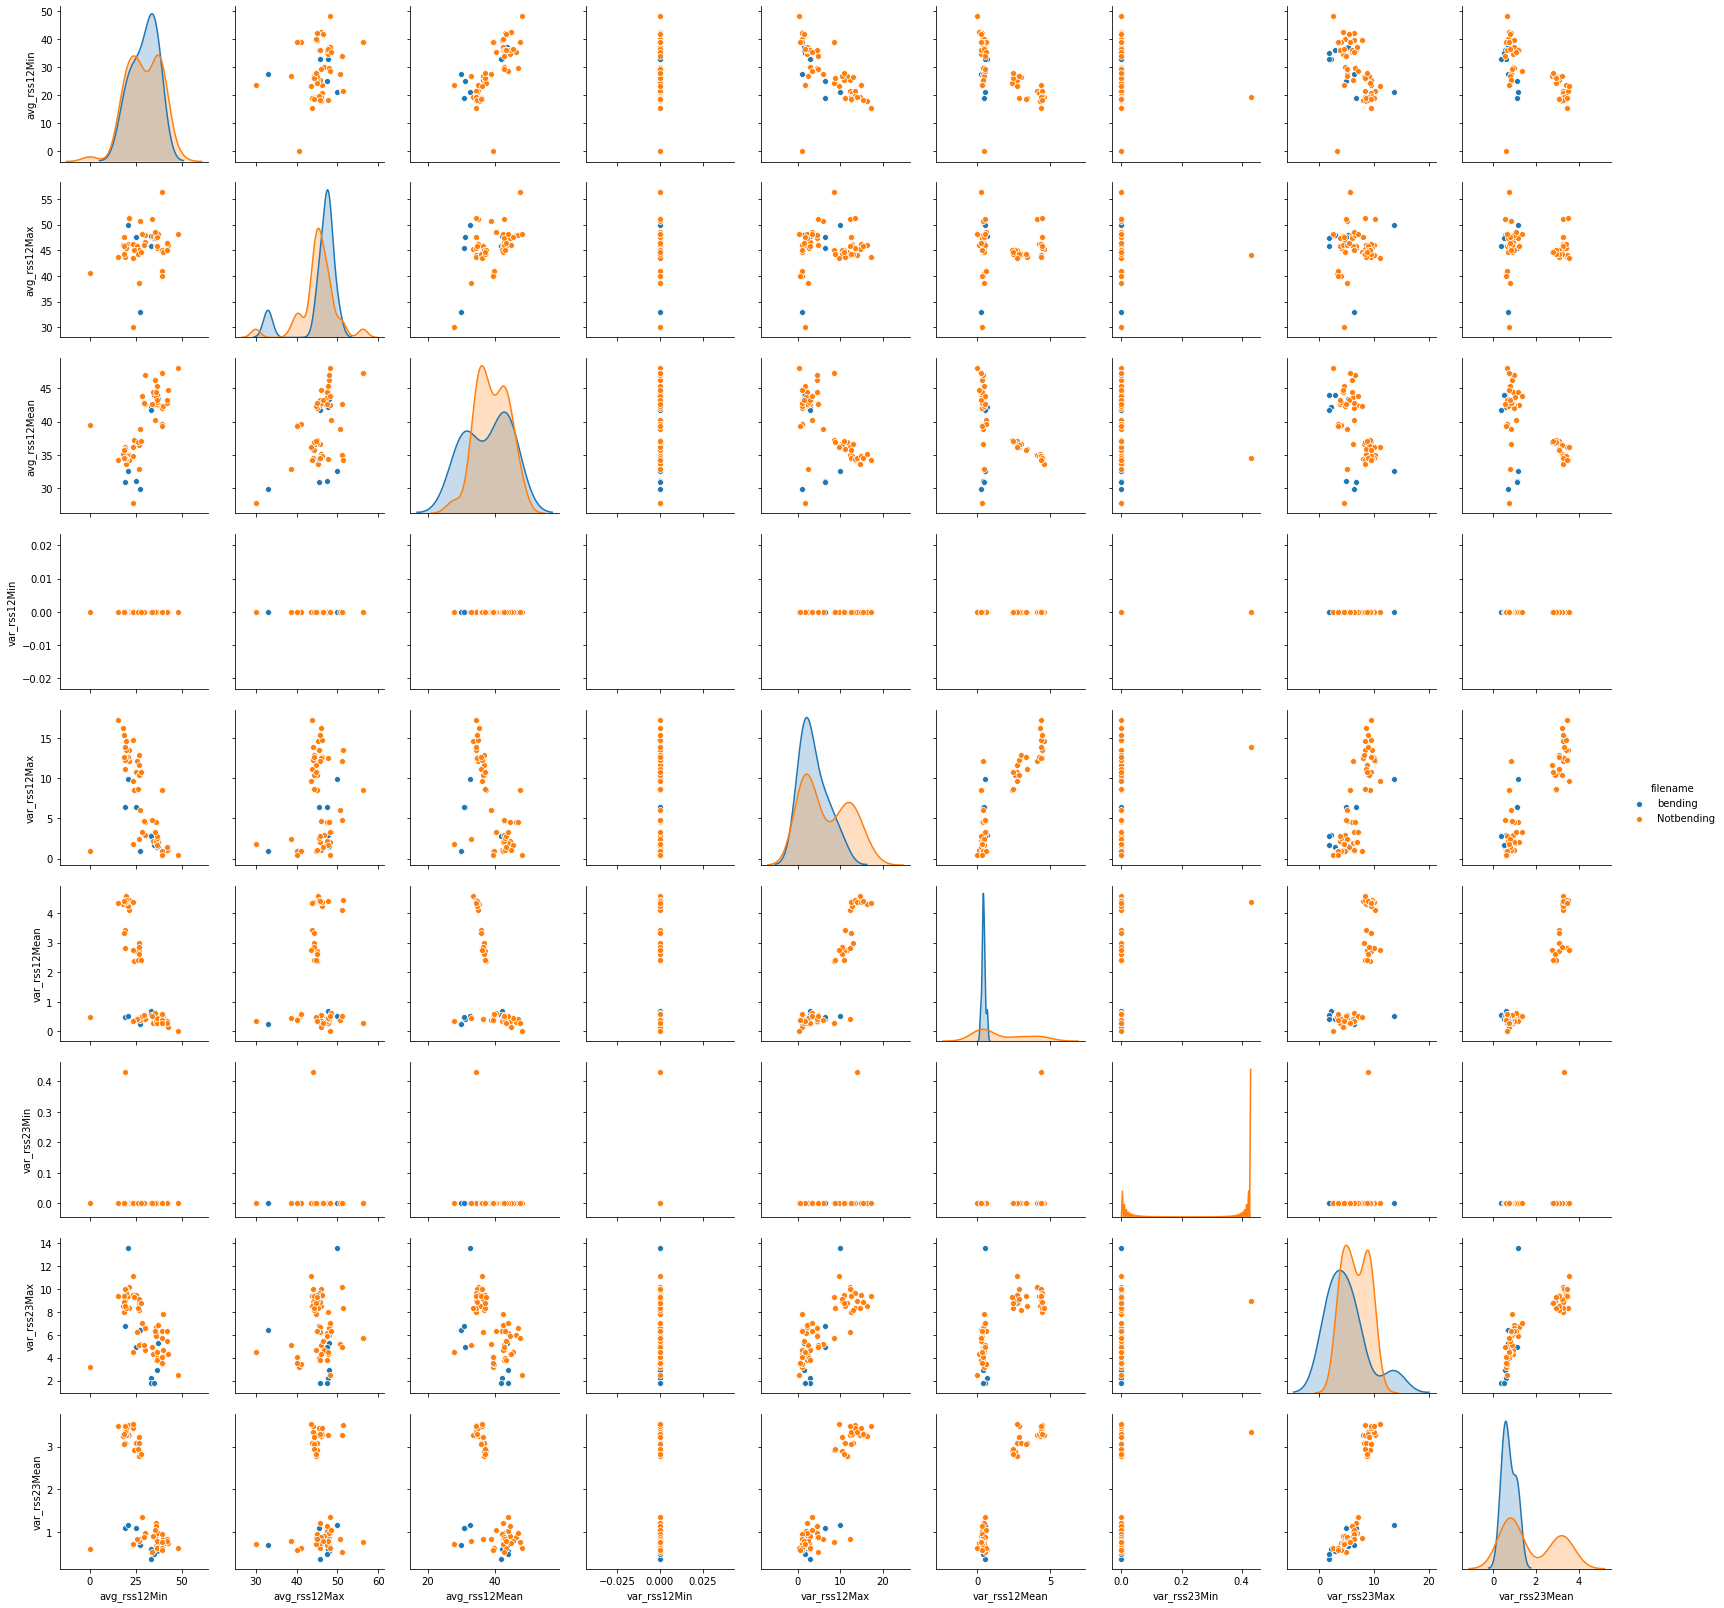

In [133]:
#draw the paitplot
seaborn.pairplot(df_4a, hue = 'filename', kind = 'scatter')

#### Break each time series in your training set into two (approximately) equal length time series. Now instead of 6 time series for each of the training instances, you have 12 time series for each training instance. Repeat the experiment in 4(a)i, i.e depict scatter plots of the features extracted from both parts of the time series 1,2, and 6. Do you see any considerable di erence in the results with those of 4(a)i?

In [171]:
variable_names = ['avg_rss12', 'var_rss12', 'var_rss23', 'avg_rss12_2nd', 'var_rss12_2nd', 'var_rss23_2nd']
column_names = []
for name in variable_names:
    column_names.append(name + 'Min')
    column_names.append(name + 'Max')
    column_names.append(name + 'Mean')
column_names.append('filename')
df_4b = pd.DataFrame(columns = column_names)
for file in train_name:
    newline = []
    new_file = file.split('/')[-2:]
    new_name = '/'.join(name for name in new_file)
    if new_name != 'bending2/dataset4.csv':
        newfile = pd.read_csv(file, skiprows = 4, error_bad_lines = False, warn_bad_lines = False)
        listDataframe = np.array_split(newfile, 2)
        concatDataframe = pd.concat([listDataframe[0], listDataframe[1].reset_index()], axis=1)
        concatDataframe.drop(['# Columns: time', 'avg_rss13', 'var_rss13', 'avg_rss23', 'index'], axis=1, inplace=True)
    else:
        headers = ['columns', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
        newfile = pd.read_csv('../AreM/bending2/dataset4.csv', skiprows = 5, error_bad_lines = False, warn_bad_lines = False, sep = '\s+', names = headers)
        listDataframe = np.array_split(newfile, 2)
        concatDataframe = pd.concat([listDataframe[0], listDataframe[1].reset_index()], axis=1)
        concatDataframe.drop(['columns', 'avg_rss13', 'var_rss13', 'avg_rss23', 'index'], axis=1, inplace=True)
    for n in range(0,len(concatDataframe.columns)):
        column = concatDataframe.iloc[:, n]
        newline.append(column.min())
        newline.append(column.max())
        newline.append(column.mean())
    if 'bending' in file:
        newline.append('bending')
    else:
        newline.append('Notbending')
    df_4b.loc[len(df_4b.index)] = newline
df_4b

,avg_rss12Min,avg_rss12Max,avg_rss12Mean,var_rss12Min,var_rss12Max,var_rss12Mean,var_rss23Min,var_rss23Max,var_rss23Mean,avg_rss12_2ndMin,avg_rss12_2ndMax,avg_rss12_2ndMean,var_rss12_2ndMin,var_rss12_2ndMax,var_rss12_2ndMean,var_rss23_2ndMin,var_rss23_2ndMax,var_rss23_2ndMean,filename
0,36.67,45.00,43.486208,0.0,1.30,0.378667,0.0,2.28,0.524875,36.25,48.00,44.452042,0.0,1.50,0.447583,0.0,2.96,0.585750,bending
1,39.00,48.00,44.117042,0.0,1.30,0.250042,0.0,5.26,0.815417,37.00,46.50,42.792875,0.0,1.58,0.506125,0.0,4.06,0.543875,bending
2,33.75,47.75,43.278875,0.0,3.00,0.673292,0.0,1.53,0.640958,33.00,46.00,41.080750,0.0,2.86,0.718792,0.0,2.18,0.586083,bending
3,33.00,45.75,41.621208,0.0,2.83,0.623083,0.0,1.79,0.419083,39.25,43.67,41.734917,0.0,1.12,0.448875,0.0,1.50,0.347500,bending
4,36.50,46.50,44.057167,0.0,1.50,0.381042,0.0,1.79,0.598250,35.00,47.40,43.851833,0.0,1.70,0.471458,0.0,1.50,0.388333,bending
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,20.00,44.25,35.692167,0.0,11.39,3.324208,0.0,9.39,3.172417,18.50,44.00,35.812542,0.0,12.60,3.332000,0.0,8.81,2.966917,Notbending
65,24.25,45.00,36.954208,0.0,8.18,2.392667,0.0,9.07,3.005375,29.00,44.67,37.399875,0.0,8.58,2.355750,0.0,9.34,2.838083,Notbending
66,27.00,42.67,36.342750,0.0,9.71,2.691917,0.0,9.57,3.547750,23.33,43.50,36.145417,0.0,9.63,2.780125,0.0,11.15,3.513250,Notbending
67,26.25,43.40,36.865417,0.0,7.46,2.387250,0.0,8.26,2.964792,29.25,44.25,37.049500,0.0,8.64,2.452917,0.0,8.34,2.904458,Notbending


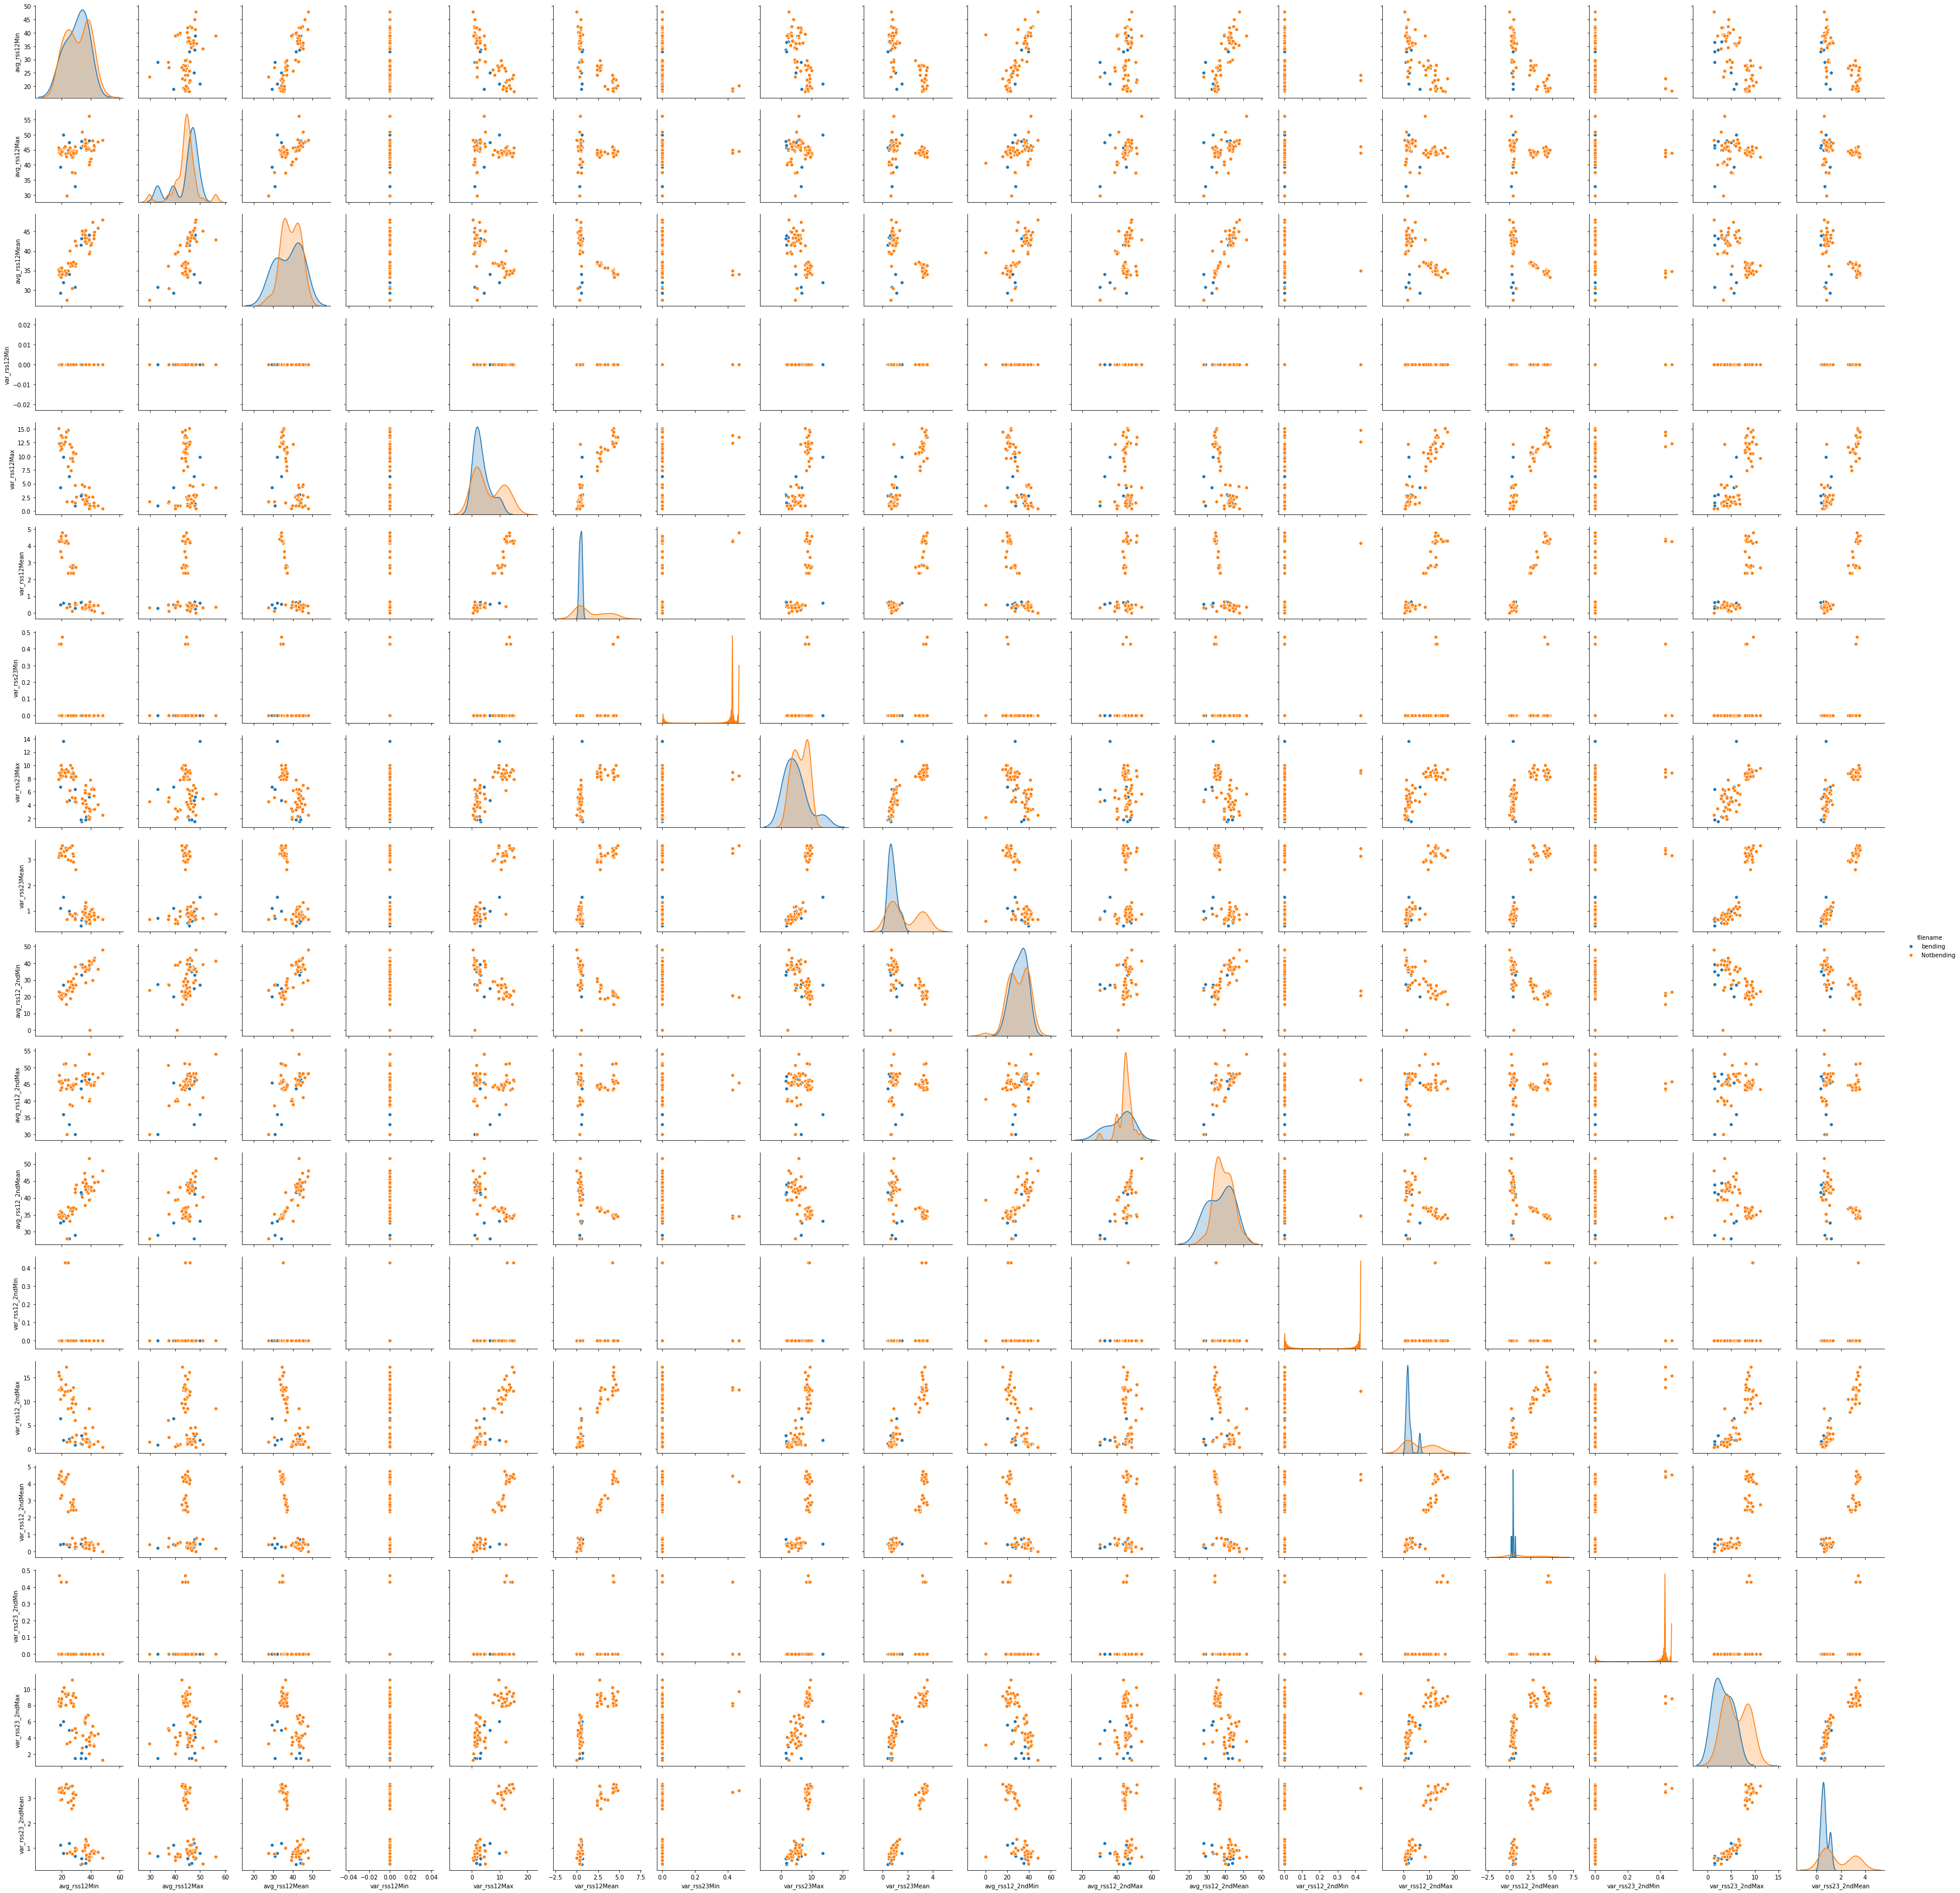

In [172]:
#draw the paitplot
seaborn.pairplot(df_4b, hue = 'filename', kind = 'scatter')

#### I don't think there's that much diference between the two graphs except the second one has more clear view on the data

In [289]:
# test data
model = LogisticRegression(penalty = 'none', solver = 'lbfgs')
stratifiedCV = StratifiedKFold(n_splits = 5)
selector = RFECV(estimator = model, cv = stratifiedCV, scoring = 'accuracy')
X_train = df_4b.loc[:, df_4b.columns != 'filename']
y_train = df_4b['filename']
selector.fit(X_train, y_train)
print(selector.grid_scores_)

[0.84175824 0.82747253 0.7989011  0.82747253 0.82747253 0.81318681
 0.87032967 0.87032967 0.87032967 0.88461538 0.88461538 0.88461538
 0.87032967 0.92747253 0.8989011  0.91318681 0.8989011  0.8989011 ]


#### Break each time series in your training set into l 2 f1; 2; : : : ; 20g time series of approximately equal length and use logistic regression5 to solve the binary classification problem, using time-domain features.

In [322]:
#loop throught the 1 to 20 to find the best l
variable_names = ['avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
for n in range(1,21):
    column_names = []
    for i in range(0,n):
        for name in variable_names:
            column_names.append(name + 'Min')
            column_names.append(name + 'Max')
            column_names.append(name + 'Mean')
    column_names.append('filename')
    df_4c = pd.DataFrame(columns = column_names)
    for file in train_name:
        newline = []
        new_file = file.split('/')[-2:]
        new_name = '/'.join(name for name in new_file)
        if n > 1:
            if new_name != 'bending2/dataset4.csv':
                newfile = pd.read_csv(file, skiprows = 4, error_bad_lines = False, warn_bad_lines = False)
                listDataframe = np.array_split(newfile, n)
                concatDataframe = pd.concat([listDataframe[0], listDataframe[1].reset_index()], axis=1)
                if n > 2:
                    for s in range(2,n):
                        concatDataframe = pd.concat([concatDataframe, listDataframe[s]], axis=1)
                concatDataframe.drop(['# Columns: time', 'index'], axis=1, inplace=True)
            else:
                headers = ['columns', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
                newfile = pd.read_csv('../AreM/bending2/dataset4.csv', skiprows = 5, error_bad_lines = False, warn_bad_lines = False, sep = '\s+', names = headers)
                listDataframe = np.array_split(newfile, n)
                concatDataframe = pd.concat([listDataframe[0], listDataframe[1].reset_index()], axis=1)
                if n > 2:
                    for s in range(2,n):
                        concatDataframe = pd.concat([concatDataframe, listDataframe[s]], axis=1)
                concatDataframe.drop(['columns', 'index'], axis=1, inplace=True)
        else:
            if new_name != 'bending2/dataset4.csv':
                concatDataframe = pd.read_csv(file, skiprows = 4, error_bad_lines = False, warn_bad_lines = False)
                concatDataframe.drop(['# Columns: time'], axis=1, inplace=True)
            else:
                headers = ['columns', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
                concatDataframe = pd.read_csv('../AreM/bending2/dataset4.csv', skiprows = 5, error_bad_lines = False, warn_bad_lines = False, sep = '\s+', names = headers)
                concatDataframe.drop(['columns'], axis=1, inplace=True)
        for l in range(0,len(concatDataframe.columns)):
            column = concatDataframe.iloc[:, l]
            newline.append(column.min())
            newline.append(column.max())
            newline.append(column.mean())
        if 'bending' in file:
            newline.append(1)
        else:
            newline.append(0)
        df_4c.loc[len(df_4c.index)] = newline
    model = LogisticRegression(penalty = 'none', solver = 'lbfgs')
    stratifiedCV = StratifiedKFold(n_splits = 5)
    selector = RFECV(estimator = model, cv = stratifiedCV, scoring = 'accuracy')
    X_train = df_4c.loc[:, df_4c.columns != 'filename']
    y_train = df_4c['filename']
    selector.fit(X_train, y_train)
    p_value = selector.n_features_
    best = round(max(selector.grid_scores_), 2)
    print(n, p_value, best)
    

1 10 0.99
2 13 0.97
3 3 0.97
4 29 0.97
5 8 0.96
6 36 0.97
7 13 0.97
8 4 0.96
9 4 0.96
10 5 0.97
11 4 0.97
12 4 0.99
13 4 0.99
14 6 0.99
15 10 0.97
16 13 0.99
17 15 0.99
18 10 0.99
19 15 1.0
20 8 0.99


In [501]:
# define the function to split the dataframe
def splitDataframeTrain(n, multi):
    column_names = []
    for i in range(0,n):
        for name in variable_names:
            column_names.append(name + 'Min')
            column_names.append(name + 'Max')
            column_names.append(name + 'Mean')
    column_names.append('filename')
    df_new = pd.DataFrame(columns = column_names)
    for file in train_name:
        newline = []
        new_file = file.split('/')[-2:]
        fname = new_file[0]
        new_name = '/'.join(name for name in new_file)
        if n > 1:
            if new_name != 'bending2/dataset4.csv':
                newfile = pd.read_csv(file, skiprows = 4, error_bad_lines = False, warn_bad_lines = False)
                listDataframe = np.array_split(newfile, n)
                concatDataframe = pd.concat([listDataframe[0], listDataframe[1].reset_index()], axis=1)
                if n > 2:
                    for s in range(2,n):
                        concatDataframe = pd.concat([concatDataframe, listDataframe[s]], axis=1)
                concatDataframe.drop(['# Columns: time', 'index'], axis=1, inplace=True)
            else:
                headers = ['columns', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
                newfile = pd.read_csv('../AreM/bending2/dataset4.csv', skiprows = 5, error_bad_lines = False, warn_bad_lines = False, sep = '\s+', names = headers)
                listDataframe = np.array_split(newfile, n)
                concatDataframe = pd.concat([listDataframe[0], listDataframe[1].reset_index()], axis=1)
                if n > 2:
                    for s in range(2,n):
                        concatDataframe = pd.concat([concatDataframe, listDataframe[s]], axis=1)
                concatDataframe.drop(['columns', 'index'], axis=1, inplace=True)
        else:
            if new_name != 'bending2/dataset4.csv':
                concatDataframe = pd.read_csv(file, skiprows = 4, error_bad_lines = False, warn_bad_lines = False)
                concatDataframe.drop(['# Columns: time'], axis=1, inplace=True)
            else:
                headers = ['columns', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
                concatDataframe = pd.read_csv('../AreM/bending2/dataset4.csv', skiprows = 5, error_bad_lines = False, warn_bad_lines = False, sep = '\s+', names = headers)
                concatDataframe.drop(['columns'], axis=1, inplace=True)
        for l in range(0,len(concatDataframe.columns)):
            column = concatDataframe.iloc[:, l]
            newline.append(column.min())
            newline.append(column.max())
            newline.append(column.mean())
        if multi != 'multi':
            if 'bending' in file:
                newline.append(1)
            else:
                newline.append(0)
        else:
            newline.append(fname)
        df_new.loc[len(df_new.index)] = newline
    return df_new

In [505]:
# define the function to split the dataframe
def splitDataframeTest(n, multi):
    column_names = []
    for i in range(0,n):
        for name in variable_names:
            column_names.append(name + 'Min')
            column_names.append(name + 'Max')
            column_names.append(name + 'Mean')
    column_names.append('filename')
    df_new = pd.DataFrame(columns = column_names)
    for file in test_name:
        newline = []
        new_file = file.split('/')[-2:]
        fname = new_file[0]
        new_name = '/'.join(name for name in new_file)
        if n > 1:
            if new_name != 'bending2/dataset4.csv':
                newfile = pd.read_csv(file, skiprows = 4, error_bad_lines = False, warn_bad_lines = False)
                listDataframe = np.array_split(newfile, n)
                concatDataframe = pd.concat([listDataframe[0], listDataframe[1].reset_index()], axis=1)
                if n > 2:
                    for s in range(2,n):
                        concatDataframe = pd.concat([concatDataframe, listDataframe[s]], axis=1)
                concatDataframe.drop(['# Columns: time', 'index'], axis=1, inplace=True)
            else:
                headers = ['columns', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
                newfile = pd.read_csv('../AreM/bending2/dataset4.csv', skiprows = 5, error_bad_lines = False, warn_bad_lines = False, sep = '\s+', names = headers)
                listDataframe = np.array_split(newfile, n)
                concatDataframe = pd.concat([listDataframe[0], listDataframe[1].reset_index()], axis=1)
                if n > 2:
                    for s in range(2,n):
                        concatDataframe = pd.concat([concatDataframe, listDataframe[s]], axis=1)
                concatDataframe.drop(['columns', 'index'], axis=1, inplace=True)
        else:
            if new_name != 'bending2/dataset4.csv':
                concatDataframe = pd.read_csv(file, skiprows = 4, error_bad_lines = False, warn_bad_lines = False)
                concatDataframe.drop(['# Columns: time'], axis=1, inplace=True)
            else:
                headers = ['columns', 'avg_rss12', 'var_rss12', 'avg_rss13', 'var_rss13', 'avg_rss23', 'var_rss23']
                concatDataframe = pd.read_csv('../AreM/bending2/dataset4.csv', skiprows = 5, error_bad_lines = False, warn_bad_lines = False, sep = '\s+', names = headers)
                concatDataframe.drop(['columns'], axis=1, inplace=True)
        for l in range(0,len(concatDataframe.columns)):
            column = concatDataframe.iloc[:, l]
            newline.append(column.min())
            newline.append(column.max())
            newline.append(column.mean())
        if multi != 'multi':
            if 'bending' in file:
                newline.append(1)
            else:
                newline.append(0)
        else:
            newline.append(fname)
        df_new.loc[len(df_new.index)] = newline
    return df_new

In [348]:
#run the logistic regression on the best l
df_4d = splitDataframeTrain(19)
model = LogisticRegression(penalty = 'none', solver = 'lbfgs')
stratifiedCV = StratifiedKFold(n_splits = 5)
selector = RFECV(estimator = model, cv = stratifiedCV, scoring = 'accuracy')
X_train = df_4d.loc[:, df_4d.columns != 'filename']
y_train = df_4d[['filename']]
selector.fit(X_train, y_train)
p_value = selector.n_features_
best = round(max(selector.grid_scores_), 2)
X_train_new = X_train.loc[:, selector.support_]

In [321]:
X_train_new = sm.add_constant(X_train_new)
log_reg = sm.Logit(y_train, X_train_new).fit(method="bfgs")
print(log_reg.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 23
         Function evaluations: 27
         Gradient evaluations: 27
                           Logit Regression Results                           
Dep. Variable:               filename   No. Observations:                   69
Model:                          Logit   Df Residuals:                       53
Method:                           MLE   Df Model:                           15
Date:                Thu, 03 Mar 2022   Pseudo R-squ.:                   1.000
Time:                        15:38:13   Log-Likelihood:            -1.1065e-05
converged:                       True   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 3.263e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0061   8.47e+04   -7.

#### Report the confusion matrix and show the ROC and AUC for your classier on train data. Report the parameters of your logistic regression's as well as the p-values associated with them.

confusion matrix is [[60  0]
 [ 0  9]]


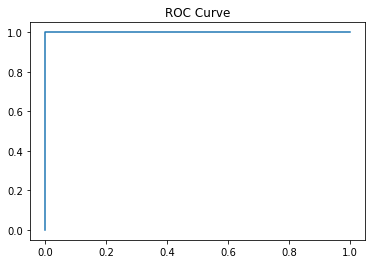

In [346]:
y_predict = log_reg.predict(X_train_new)
y_predict_new = np.where(y_predict < 0.5, 0, 1)
C_matrix = confusion_matrix(y_train.to_numpy(), y_predict_new)
fpr, tpr, thresholds = metrics.roc_curve(y_train.to_numpy(), y_predict_new, pos_label = 1)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
print('confusion matrix is',C_matrix)
auc = metrics.auc(fpr, tpr)

#### Test the classier on the test set. Remember to break the time series in your test set into the same number of time series into which you broke your training set. Remember that the classi er has to be tested using the features extracted from the test set. Compare the accuracy on the test set with the cross-validation accuracy you obtained previously.

In [356]:
df_4e = splitDataframeTest(19, 'Nonmulti')
X_test = df_4e.loc[:, df_4d.columns != 'filename']
y_test = df_4e[['filename']]
X_test_new = X_test.loc[:, selector.support_]
X_test_new = sm.add_constant(X_test_new)
y_test_predict = log_reg.predict(X_test_new)
y_test_predict_new = np.where(y_test_predict < 0.5, 0, 1)
score = accuracy_score(y_test, y_test_predict_new)
print('The test score is: ', score)
print('The confusion matric is: ',confusion_matrix(y_test.to_numpy(), y_test_predict_new))

The test score is:  1.0
The confusion matric is:  [[15  0]
 [ 0  4]]


#### The score of this model is very high that there's no flase prediction in this model, and the number of true positive and false positive is imbalence. So I don't think the classes is well seperated to cause instability in logistic regression 

#### From the confusion matrices you obtained, do you see imbalanced classes? If yes, build a logistic regression model based on case-control sampling and adjust its parameters. Report the confusion matrix, ROC, and AUC of the model.

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28
confusion matrix is [[60  0]
 [ 0 60]]
1.0


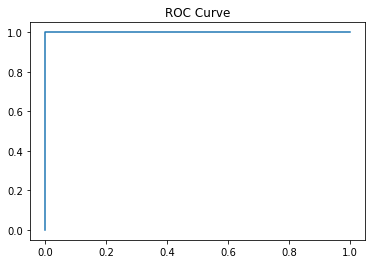

In [367]:
smo = SMOTE(random_state=42)
X_res, y_res = smo.fit_resample(X_train_new, y_train)
log_reg_new = sm.Logit(y_res, X_res).fit(method="bfgs")
y_predict = log_reg_new.predict(X_res)
y_predict_new = np.where(y_predict < 0.5, 0, 1)
C_matrix = confusion_matrix(y_res, y_predict_new)
fpr, tpr, thresholds = metrics.roc_curve(y_res, y_predict_new, pos_label = 1)
plt.plot(fpr, tpr)
plt.title('ROC Curve')
print('confusion matrix is',C_matrix)
auc = metrics.auc(fpr, tpr)
print(auc)

### b) binary classification using l1-panlized regression

In [536]:
# Using the logisticregressionCV
for l in range(1,21):
    df_5a = splitDataframeTrain(l, 'Nonmulti')
    X_train = df_5a.loc[:, df_5a.columns != 'filename']
    X_normalized = preprocessing.normalize(X_train, norm='l2')
    y_train = df_5a[['filename']]
    clf = LogisticRegressionCV(cv=5, random_state=0, penalty = 'l1', solver = 'liblinear').fit(X_normalized, y_train)
    Cs = clf.Cs_
    C = clf.C_
    index = np.where(Cs == C)[0]
    scores = []
    for i in range(0,5):
        bestC = clf.scores_[1.0][i]
        scores.append(bestC[index])
    BestScore = sum(scores)/len(scores)
    print(l, C, BestScore)

1 [21.5443469] [0.95714286]
2 [21.5443469] [0.95714286]
3 [21.5443469] [0.95714286]
4 [21.5443469] [0.95714286]
5 [166.81005372] [0.94285714]
6 [21.5443469] [0.94285714]
7 [21.5443469] [0.95714286]
8 [166.81005372] [0.95714286]
9 [166.81005372] [0.95714286]
10 [166.81005372] [0.95714286]
11 [166.81005372] [0.95714286]
12 [1291.54966501] [0.97142857]
13 [166.81005372] [0.97142857]
14 [166.81005372] [0.97142857]
15 [10000.] [0.94285714]
16 [1291.54966501] [0.97142857]
17 [1291.54966501] [0.95714286]
18 [166.81005372] [0.94285714]
19 [10000.] [0.95714286]
20 [1291.54966501] [0.98571429]


In [464]:
#Using the LassoCV
for l in range(1,21):
    # import the train and test dataset
    df_5a = splitDataframeTrain(l, 'Nonmulti')
    df_5a_test = splitDataframeTest(l, 'Nonmulti')

    # spliting the x and y data for both train and test dataset
    X_train = df_5a.loc[:, df_5a.columns != 'filename']
    y_train = df_5a[['filename']]

    X_test = df_5a_test.loc[:, df_5a_test.columns != 'filename']
    y_test = df_5a_test[['filename']]

    # Lasso cross validation
    reg = LassoCV(cv=5, random_state=0).fit(X_train, y_train)
    alpha = reg.alpha_
    coefs = reg.coef_
    p_value = 0
    for coef in coefs:
        if coef != 0:
            p_value += 1
        
    # Logistic Regression
    model_l1 = LogisticRegression(penalty = 'l1', solver = 'liblinear', C = 1/alpha).fit(X_train, y_train)
    X_predict = model_l1.predict(X_test)
    score = model_l1.score(X_test, y_test)
    print(l, p_value, score)

1 8 1.0
2 11 1.0
3 13 1.0
4 29 1.0
5 16 1.0
6 47 0.9473684210526315
7 48 1.0
8 40 0.9473684210526315
9 32 1.0
10 70 1.0
11 34 1.0
12 18 1.0
13 29 1.0
14 67 1.0
15 47 1.0
16 31 1.0
17 22 1.0
18 41 1.0
19 30 0.9473684210526315
20 48 1.0


#### Personally, I think the l1 panalized is better. Because lasso would give every parameter a coefficient to evaluate their importance. And most importantly, is easier to conduct.

### c) Multi-Class Classification

In [545]:
for l in range(1,21):
    df_6a = splitDataframeTrain(l, 'multi')
    X_train = df_6a.loc[:, df_6a.columns != 'filename']
    y_train = df_6a[['filename']]
    clf_multi = LogisticRegressionCV(cv=5, random_state=0, penalty = 'l1', solver = 'liblinear').fit(X_train, y_train)
    Cs_multi = clf_multi.Cs_
    C_multi = clf_multi.C_
    np.where(Cs_multi == C_multi)[0]
    ss = clf_multi.scores_
    scores = []
    n = 0
    for key in ss.keys():
        fileC = ss.get(key)
        index = np.where(Cs_multi == C_multi[i])[0]
        n += 1
        for i in range(0,5):
            bestC = fileC[i]
            scores.append(bestC[index])
    BestScore = sum(scores)/len(scores)
    BBScore = BestScore[0]
    print(l, C_multi, BBScore)

1 [1.66810054e+02 3.59381366e-01 1.29154967e+03 2.15443469e+01
 1.00000000e-04 2.15443469e+01 3.59381366e-01] 0.857142857142857
2 [2.15443469e+01 3.59381366e-01 1.00000000e+04 2.78255940e+00
 3.59381366e-01 1.66810054e+02 1.66810054e+02] 0.9149732620320855
3 [3.59381366e-01 2.78255940e+00 1.00000000e+04 2.78255940e+00
 2.15443469e+01 1.00000000e-04 1.66810054e+02] 0.9193659281894574
4 [4.64158883e-02 1.00000000e+04 1.29154967e+03 2.78255940e+00
 1.29154967e+03 2.78255940e+00 1.66810054e+02] 0.9276292335115865
5 [4.64158883e-02 1.00000000e+04 1.29154967e+03 3.59381366e-01
 3.59381366e-01 1.29154967e+03 1.66810054e+02] 0.9126432391138274
6 [4.64158883e-02 2.15443469e+01 1.29154967e+03 3.59381366e-01
 2.78255940e+00 2.15443469e+01 1.66810054e+02] 0.9281385281385282
7 [4.64158883e-02 2.15443469e+01 1.29154967e+03 3.59381366e-01
 2.78255940e+00 1.00000000e+04 1.66810054e+02] 0.92602495543672
8 [1.00000000e+04 3.59381366e-01 1.66810054e+02 1.66810054e+02
 1.29154967e+03 1.00000000e+04 1.6681

In [568]:
df_6b = splitDataframeTrain(15, 'multi')
df_6b_test = splitDataframeTest(15, 'multi')
X_train = df_6b.loc[:, df_6b.columns != 'filename']
y_train = df_6b[['filename']]
clf_multi = LogisticRegressionCV(cv=5, random_state=0, penalty = 'l1', solver = 'liblinear').fit(X_train, y_train)
X_test = df_6b_test.loc[:, df_6b_test.columns != 'filename']
y_test = df_6b_test[['filename']]
X_predict = clf_multi.predict(X_test)
C_matrix = confusion_matrix(y_test, X_predict)
print('confusion matrix is',C_matrix)
print('The test score is: ', score)

confusion matrix is [[2 0 0 0 0 0 0]
 [1 0 0 0 0 1 0]
 [0 1 2 0 0 0 0]
 [0 0 0 3 0 0 0]
 [0 1 0 0 2 0 0]
 [0 2 0 0 0 1 0]
 [0 0 0 0 0 0 3]]
The test score is:  0.6842105263157895


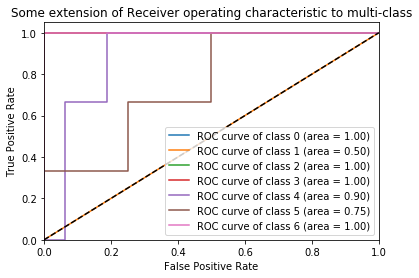

In [572]:
# ploting the ROC curve
classes = ['bending1', 'bending2', 'cycling', 'lying', 'sitting', 'standing', 'walking']
new_y_test = label_binarize(y_test, classes = classes)
n_classes = new_y_test.shape[1]
y_score = clf_multi.fit(X_train, y_train).decision_function(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(new_y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [577]:
# Naive Bayes Gaussian
for l in range(1,21):
    df_6c = splitDataframeTrain(l, 'multi')
    df_6c_test = splitDataframeTest(l, 'multi')
    X_train = df_6c.loc[:, df_6c.columns != 'filename']
    y_train = df_6c[['filename']]
    X_test = df_6c_test.loc[:, df_6c_test.columns != 'filename']
    y_test = df_6c_test[['filename']]
    clf = GaussianNB()
    clf.fit(X_train, y_train)
    X_predict = clf.predict(X_test)
    accuracy_score = metrics.accuracy_score(y_test, X_predict)
    print(l, accuracy_score)

1 0.9473684210526315
2 0.9473684210526315
3 0.7894736842105263
4 0.9473684210526315
5 0.7894736842105263
6 0.7368421052631579
7 0.7894736842105263
8 0.7894736842105263
9 0.8421052631578947
10 0.7894736842105263
11 0.631578947368421
12 0.7368421052631579
13 0.7368421052631579
14 0.5789473684210527
15 0.631578947368421
16 0.5263157894736842
17 0.5263157894736842
18 0.631578947368421
19 0.631578947368421
20 0.5789473684210527


In [581]:
# Naive Bayes Multi_nomial
for l in range(1,21):
    df_6d = splitDataframeTrain(l, 'multi')
    df_6d_test = splitDataframeTest(l, 'multi')
    X_train = df_6d.loc[:, df_6d.columns != 'filename']
    y_train = df_6d[['filename']]
    X_test = df_6d_test.loc[:, df_6d_test.columns != 'filename']
    y_test = df_6d_test[['filename']]
    clf = MultinomialNB()
    clf.fit(X_train, y_train)
    X_predict = clf.predict(X_test)
    accuracy_score = metrics.accuracy_score(y_test, X_predict)
    print(l, accuracy_score)

1 0.7368421052631579
2 0.7368421052631579
3 0.7894736842105263
4 0.7368421052631579
5 0.7368421052631579
6 0.7368421052631579
7 0.7368421052631579
8 0.7368421052631579
9 0.7368421052631579
10 0.7368421052631579
11 0.7894736842105263
12 0.7368421052631579
13 0.7894736842105263
14 0.7368421052631579
15 0.7368421052631579
16 0.7894736842105263
17 0.7894736842105263
18 0.7894736842105263
19 0.7894736842105263
20 0.7368421052631579


#### I think in this problem Multinomial is better. Since the Multinomial  model is for discrete variable (what we have as the targeting variable here) and the Gaussian is for continuous variable in normal distribution.